In [1]:
from src.preprocess import clean_tokens, date_to_astral

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Path for spacy/stanza data 
DOCS_PATH = Path('data/lg/spacy.pkl')

## Load data

In [3]:
# Read parsed documents
docs = pickle.loads(DOCS_PATH.read_bytes())

In [4]:
# Load metadata columns in a DataFrame
df = pd.DataFrame(docs, columns=['path', 'birthDate', 'birthPlace', 'deathDate'])
df.head()

,path,birthDate,birthPlace,deathDate
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09


In [5]:
# Compute astral signs
df['astral_sign'] = df.birthDate.apply(date_to_astral)
df.head()

,path,birthDate,birthPlace,deathDate,astral_sign
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17,Cancer
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None,Leo
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None,Aquarius
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None,Taurus
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09,Sagittarius


In [6]:
df['astral_sign'].value_counts()

Aquarius       1463
Capricorn      1459
Gemini         1456
Pisces         1447
Aries          1445
Virgo          1435
Scorpio        1431
Cancer         1420
Libra          1409
Taurus         1406
Leo            1349
Sagittarius    1258
Name: astral_sign, dtype: int64

## Classification

As we have 12 differents labels and the main goal is to do binary classifiction, we setup 2 experiments:
- Try a binary classification on "Taurus" vs "Sagittarius". (Authors astral signs)
- Try a classification on the whole corpus and the whole labels.

In [7]:
# First we split data by indices to keep "equivalent" partitions during each experiments.
train_indices, test_indices = train_test_split(list(df.index), test_size=0.3, random_state=42)

In [8]:
def vectorize(df, vectorizer, train_indices, test_indices, labels):

    # Reunify tokens as string.
    tokens = df['tokens'].apply(lambda x: ' '.join(x))
    # Fit vectorizer
    vectorizer.fit(tokens)

    # Create train and test set. 
    train_set = df.iloc[train_indices]
    test_set = df.iloc[test_indices]

    # Filter labels.
    #   If labels len is 1: Binarize labels as the result of each label == labels[0].
    #   Else if labels len is not zero: Keep only labels.
    #   Else: Keep all labels.

    if len(labels) > 0:
        train_set = train_set[train_set['astral_sign'].isin(labels)]
        test_set = test_set[test_set['astral_sign'].isin(labels)]

    # Return transformed X_train, y_train, X_test, y_test.
    return (
        vectorizer.transform(tokens[train_set.index]), # Vectorize train
        train_set['astral_sign'], # Retrieve train labels
        vectorizer.transform(tokens[test_set.index]), # Vectorize test
        test_set['astral_sign'], # Retrieve test labels
    )

def fit_model(model, X_train, y_train, X_test, y_test):
    # Fit model with train data.
    model.fit(X_train, y_train)

    # Use model to predict test data.
    y_pred = model.predict(X_test)

    # Print classification report.
    print(classification_report(y_test, y_pred))

    # Display confusion matrix.
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
        display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(10,5))
    disp.plot(ax=ax, xticks_rotation = 45)
    plt.show()


## Abstract Classification (no lemma, keep month)

In [9]:
# Load and clean abstracts
cleaner = clean_tokens(keep_lemma=False, remove_month=False)
df['tokens'] = pd.Series([cleaner(doc['abstract']) for doc in docs])
df['tokens'].describe()

count                                                 16978
unique                                                16961
top       [following, list, playboy, playmates, playboy,...
freq                                                     16
Name: tokens, dtype: object

#### Binary Classification

In [10]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, ['Taurus','Sagittarius'])

In [11]:
y_train.value_counts() / len(y_train)

Taurus         0.521119
Sagittarius    0.478881
Name: astral_sign, dtype: float64

In [12]:
y_test.value_counts() / len(y_test)

Taurus         0.542212
Sagittarius    0.457788
Name: astral_sign, dtype: float64

In [13]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1823, 68973), (1823,), (841, 68973), (841,))

##### LogisticRegression

              precision    recall  f1-score   support

 Sagittarius       0.91      0.93      0.92       385
      Taurus       0.94      0.93      0.93       456

    accuracy                           0.93       841
   macro avg       0.93      0.93      0.93       841
weighted avg       0.93      0.93      0.93       841



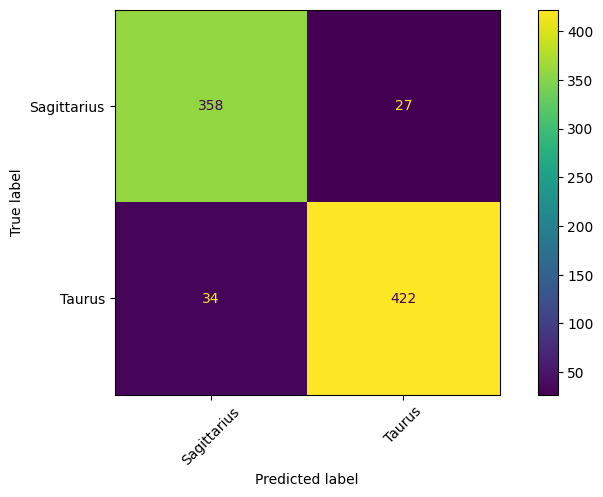

In [14]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

 Sagittarius       0.89      0.92      0.90       385
      Taurus       0.93      0.90      0.92       456

    accuracy                           0.91       841
   macro avg       0.91      0.91      0.91       841
weighted avg       0.91      0.91      0.91       841



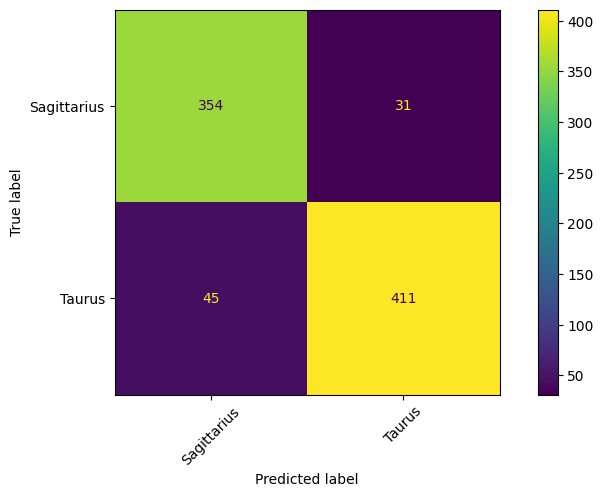

In [15]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

 Sagittarius       0.93      0.93      0.93       385
      Taurus       0.94      0.94      0.94       456

    accuracy                           0.94       841
   macro avg       0.94      0.94      0.94       841
weighted avg       0.94      0.94      0.94       841



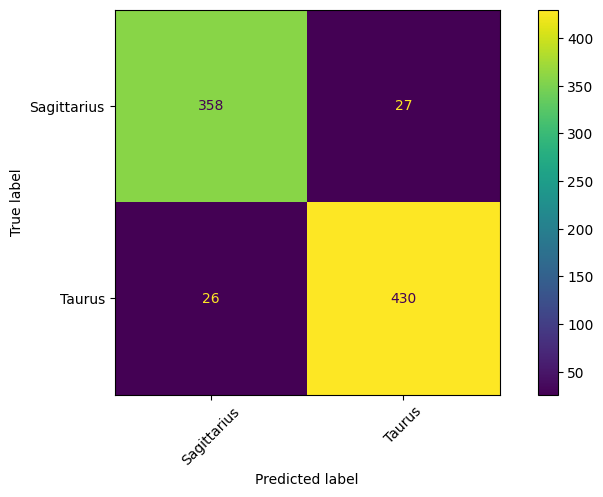

In [16]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

#### Nary Classification

In [17]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, [])

In [18]:
y_train.value_counts() / len(y_train)

Capricorn      0.088859
Aquarius       0.087176
Aries          0.085577
Libra          0.084652
Cancer         0.084652
Pisces         0.084567
Virgo          0.084399
Scorpio        0.084063
Gemini         0.082716
Taurus         0.079939
Leo            0.079939
Sagittarius    0.073460
Name: astral_sign, dtype: float64

In [19]:
y_test.value_counts() / len(y_test)

Gemini         0.092854
Taurus         0.089517
Pisces         0.086769
Scorpio        0.084806
Virgo          0.084806
Aries          0.084020
Aquarius       0.083824
Cancer         0.081272
Libra          0.079113
Capricorn      0.079113
Leo            0.078327
Sagittarius    0.075579
Name: astral_sign, dtype: float64

In [20]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((11884, 68973), (11884,), (5094, 68973), (5094,))

##### LogisticRegression

              precision    recall  f1-score   support

    Aquarius       0.51      0.46      0.49       427
       Aries       0.50      0.44      0.47       428
      Cancer       0.52      0.54      0.53       414
   Capricorn       0.45      0.49      0.47       403
      Gemini       0.53      0.50      0.51       473
         Leo       0.49      0.56      0.53       399
       Libra       0.52      0.54      0.53       403
      Pisces       0.48      0.48      0.48       442
 Sagittarius       0.47      0.51      0.49       385
     Scorpio       0.54      0.54      0.54       432
      Taurus       0.56      0.51      0.53       456
       Virgo       0.52      0.54      0.53       432

    accuracy                           0.51      5094
   macro avg       0.51      0.51      0.51      5094
weighted avg       0.51      0.51      0.51      5094



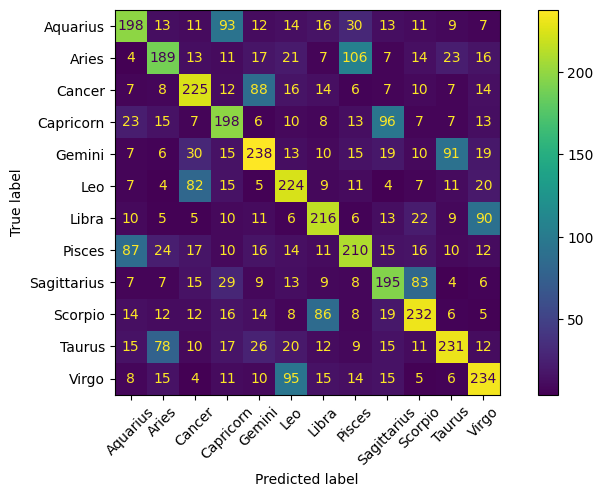

In [21]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

    Aquarius       0.40      0.46      0.43       427
       Aries       0.37      0.39      0.38       428
      Cancer       0.41      0.41      0.41       414
   Capricorn       0.37      0.41      0.39       403
      Gemini       0.46      0.41      0.43       473
         Leo       0.39      0.41      0.40       399
       Libra       0.40      0.37      0.39       403
      Pisces       0.37      0.35      0.36       442
 Sagittarius       0.39      0.37      0.38       385
     Scorpio       0.42      0.43      0.42       432
      Taurus       0.41      0.39      0.40       456
       Virgo       0.43      0.43      0.43       432

    accuracy                           0.40      5094
   macro avg       0.40      0.40      0.40      5094
weighted avg       0.40      0.40      0.40      5094



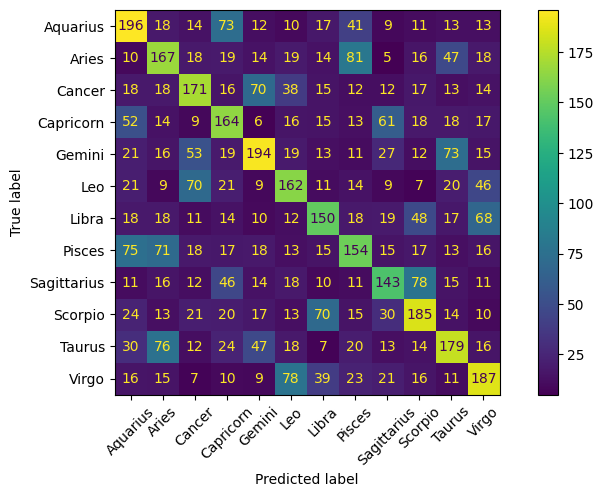

In [22]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

    Aquarius       0.49      0.42      0.45       427
       Aries       0.51      0.45      0.48       428
      Cancer       0.51      0.58      0.54       414
   Capricorn       0.41      0.53      0.46       403
      Gemini       0.56      0.48      0.52       473
         Leo       0.50      0.53      0.51       399
       Libra       0.48      0.57      0.52       403
      Pisces       0.49      0.50      0.49       442
 Sagittarius       0.51      0.52      0.52       385
     Scorpio       0.56      0.53      0.54       432
      Taurus       0.55      0.48      0.51       456
       Virgo       0.52      0.48      0.50       432

    accuracy                           0.50      5094
   macro avg       0.51      0.51      0.50      5094
weighted avg       0.51      0.50      0.50      5094



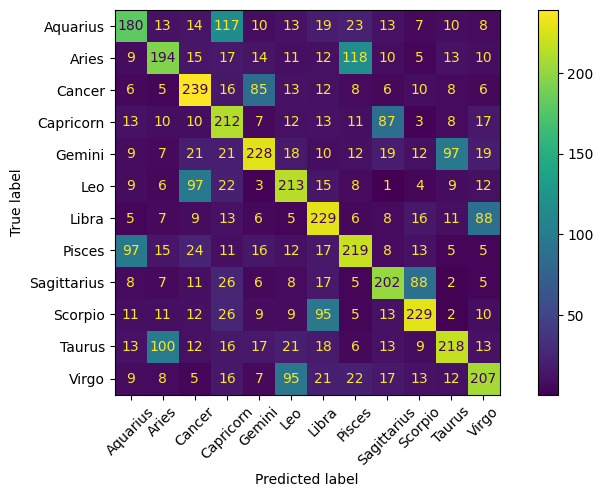

In [23]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

## Abstract Classification (no lemma, no month)

In [24]:
# Load and clean abstracts
cleaner = clean_tokens(keep_lemma=False)
df['tokens'] = pd.Series([cleaner(doc['abstract']) for doc in docs])
df['tokens'].describe()

count                                                 16978
unique                                                16961
top       [following, list, playboy, playmates, playboy,...
freq                                                     16
Name: tokens, dtype: object

#### Binary Classification

In [25]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, ['Taurus','Sagittarius'])

In [26]:
y_train.value_counts() / len(y_train)

Taurus         0.521119
Sagittarius    0.478881
Name: astral_sign, dtype: float64

In [27]:
y_test.value_counts() / len(y_test)

Taurus         0.542212
Sagittarius    0.457788
Name: astral_sign, dtype: float64

In [28]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1823, 68961), (1823,), (841, 68961), (841,))

##### LogisticRegression

              precision    recall  f1-score   support

 Sagittarius       0.47      0.45      0.46       385
      Taurus       0.55      0.56      0.55       456

    accuracy                           0.51       841
   macro avg       0.51      0.51      0.51       841
weighted avg       0.51      0.51      0.51       841



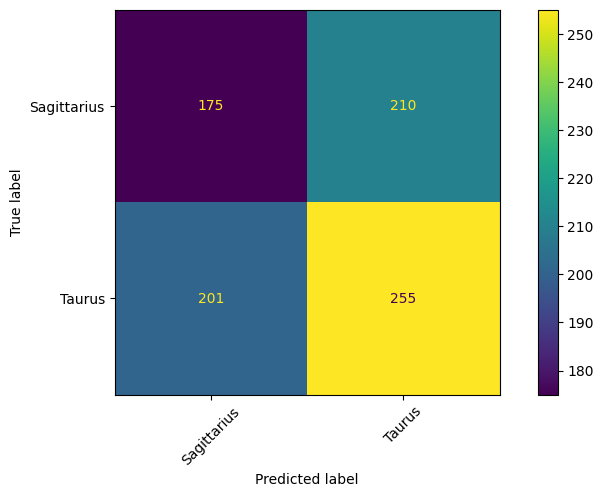

In [29]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

 Sagittarius       0.48      0.47      0.48       385
      Taurus       0.56      0.57      0.56       456

    accuracy                           0.52       841
   macro avg       0.52      0.52      0.52       841
weighted avg       0.52      0.52      0.52       841



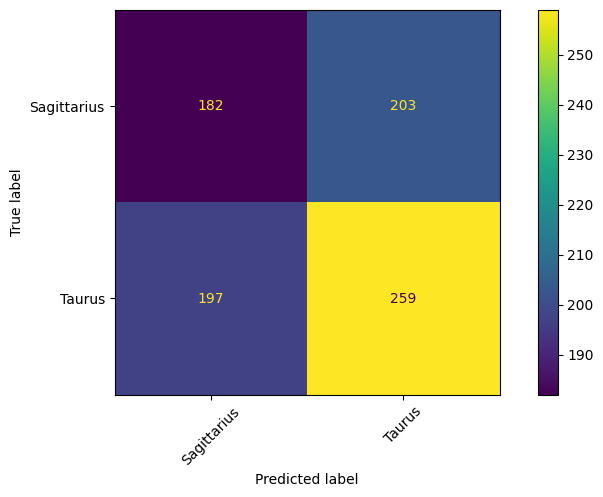

In [30]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

 Sagittarius       0.46      0.45      0.45       385
      Taurus       0.54      0.54      0.54       456

    accuracy                           0.50       841
   macro avg       0.50      0.50      0.50       841
weighted avg       0.50      0.50      0.50       841



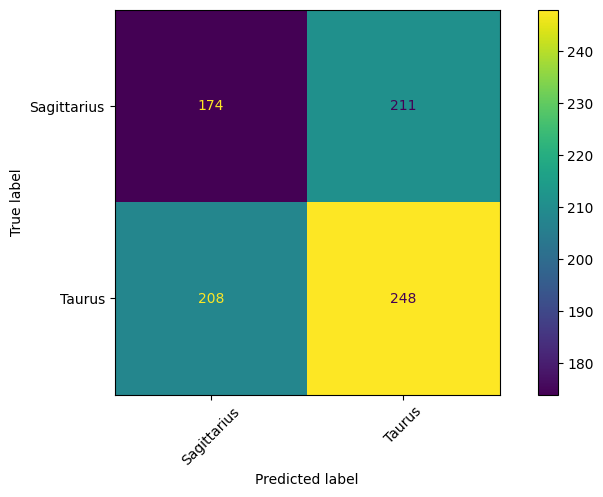

In [31]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

#### Nary Classification

In [32]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, [])

In [33]:
y_train.value_counts() / len(y_train)

Capricorn      0.088859
Aquarius       0.087176
Aries          0.085577
Libra          0.084652
Cancer         0.084652
Pisces         0.084567
Virgo          0.084399
Scorpio        0.084063
Gemini         0.082716
Taurus         0.079939
Leo            0.079939
Sagittarius    0.073460
Name: astral_sign, dtype: float64

In [34]:
y_test.value_counts() / len(y_test)

Gemini         0.092854
Taurus         0.089517
Pisces         0.086769
Scorpio        0.084806
Virgo          0.084806
Aries          0.084020
Aquarius       0.083824
Cancer         0.081272
Libra          0.079113
Capricorn      0.079113
Leo            0.078327
Sagittarius    0.075579
Name: astral_sign, dtype: float64

In [35]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((11884, 68961), (11884,), (5094, 68961), (5094,))

##### LogisticRegression

              precision    recall  f1-score   support

    Aquarius       0.08      0.09      0.08       427
       Aries       0.07      0.08      0.08       428
      Cancer       0.08      0.08      0.08       414
   Capricorn       0.08      0.09      0.09       403
      Gemini       0.09      0.07      0.08       473
         Leo       0.07      0.08      0.07       399
       Libra       0.08      0.08      0.08       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.08      0.09      0.09       385
     Scorpio       0.09      0.10      0.10       432
      Taurus       0.11      0.09      0.10       456
       Virgo       0.09      0.08      0.09       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



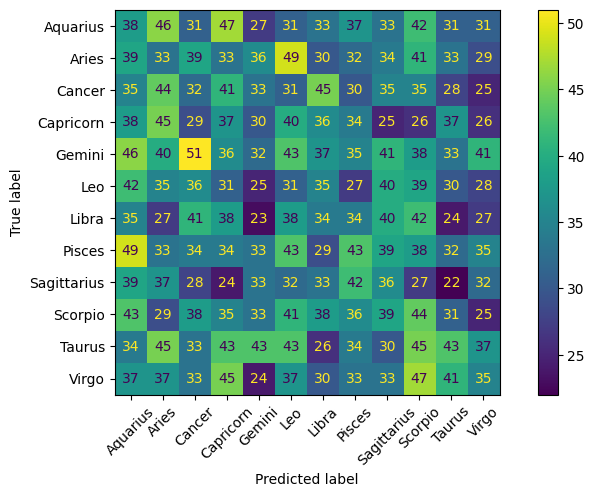

In [36]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

    Aquarius       0.10      0.12      0.11       427
       Aries       0.09      0.08      0.08       428
      Cancer       0.08      0.07      0.08       414
   Capricorn       0.08      0.10      0.09       403
      Gemini       0.09      0.08      0.08       473
         Leo       0.09      0.08      0.08       399
       Libra       0.07      0.08      0.08       403
      Pisces       0.08      0.08      0.08       442
 Sagittarius       0.09      0.08      0.08       385
     Scorpio       0.06      0.05      0.06       432
      Taurus       0.09      0.08      0.08       456
       Virgo       0.10      0.15      0.12       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



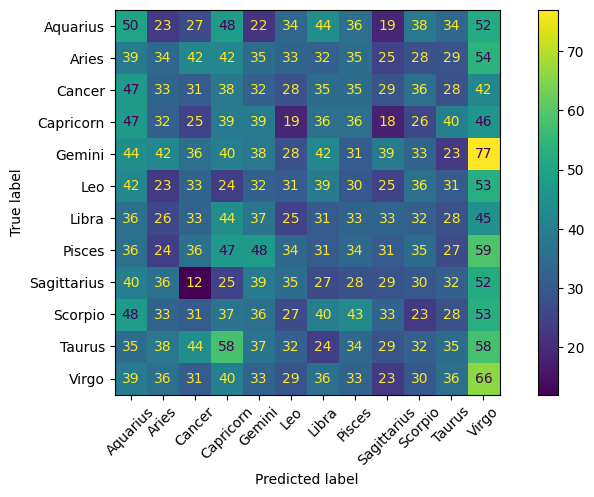

In [37]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

    Aquarius       0.09      0.13      0.11       427
       Aries       0.09      0.12      0.10       428
      Cancer       0.07      0.08      0.08       414
   Capricorn       0.09      0.13      0.10       403
      Gemini       0.08      0.06      0.07       473
         Leo       0.07      0.06      0.07       399
       Libra       0.09      0.10      0.10       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.06      0.04      0.05       385
     Scorpio       0.09      0.08      0.08       432
      Taurus       0.09      0.05      0.07       456
       Virgo       0.08      0.06      0.07       432

    accuracy                           0.09      5094
   macro avg       0.08      0.09      0.08      5094
weighted avg       0.08      0.09      0.08      5094



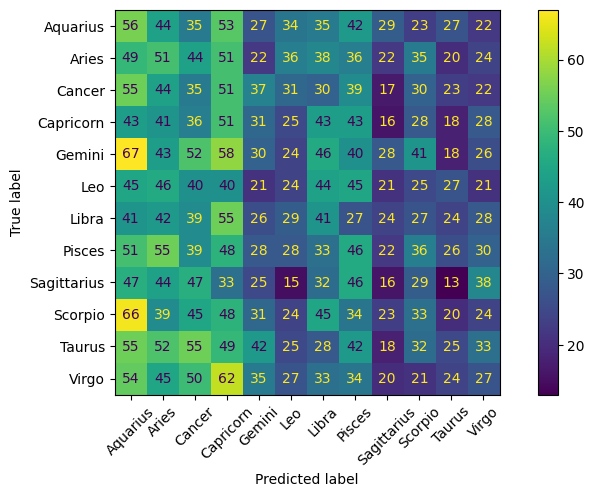

In [38]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

## Page Classification (no lemma, keep month)

In [39]:
# Load and clean abstracts
cleaner = clean_tokens(keep_lemma=False, remove_month=False)
df['tokens'] = pd.Series([cleaner(doc['abstract']) for doc in docs])
df['tokens'].describe()

count                                                 16978
unique                                                16961
top       [following, list, playboy, playmates, playboy,...
freq                                                     16
Name: tokens, dtype: object

#### Binary Classification

In [40]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, ['Taurus','Sagittarius'])

In [41]:
y_train.value_counts() / len(y_train)

Taurus         0.521119
Sagittarius    0.478881
Name: astral_sign, dtype: float64

In [42]:
y_test.value_counts() / len(y_test)

Taurus         0.542212
Sagittarius    0.457788
Name: astral_sign, dtype: float64

In [43]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1823, 68961), (1823,), (841, 68961), (841,))

##### LogisticRegression

              precision    recall  f1-score   support

 Sagittarius       0.47      0.45      0.46       385
      Taurus       0.55      0.56      0.55       456

    accuracy                           0.51       841
   macro avg       0.51      0.51      0.51       841
weighted avg       0.51      0.51      0.51       841



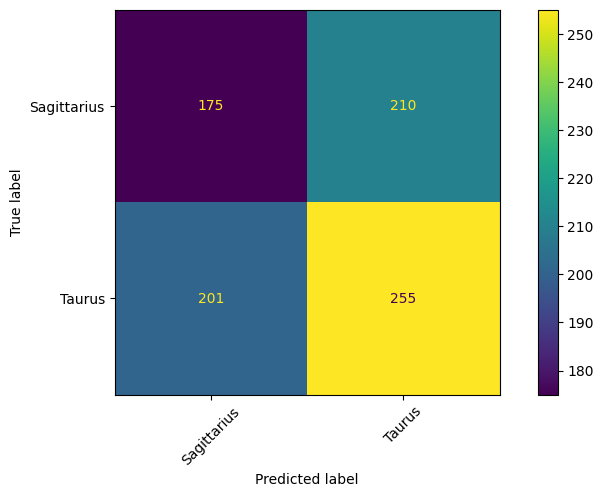

In [44]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

 Sagittarius       0.48      0.47      0.48       385
      Taurus       0.56      0.57      0.56       456

    accuracy                           0.52       841
   macro avg       0.52      0.52      0.52       841
weighted avg       0.52      0.52      0.52       841



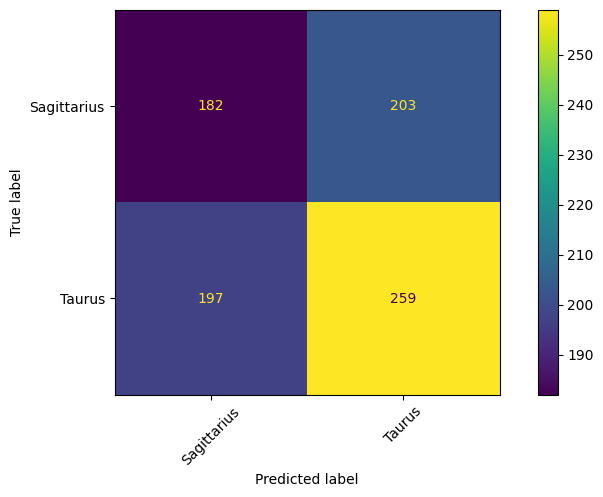

In [45]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

 Sagittarius       0.46      0.45      0.45       385
      Taurus       0.54      0.54      0.54       456

    accuracy                           0.50       841
   macro avg       0.50      0.50      0.50       841
weighted avg       0.50      0.50      0.50       841



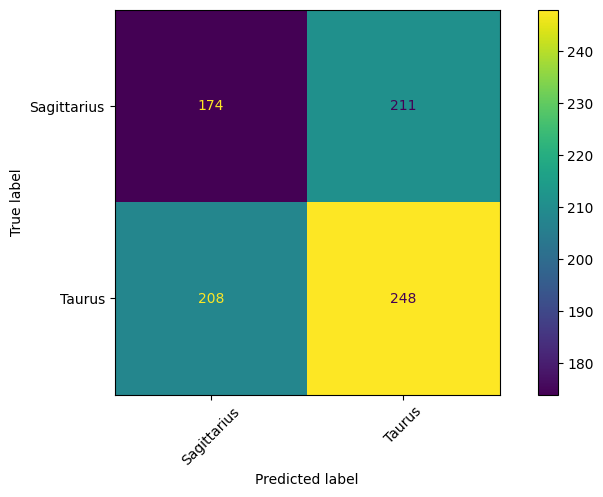

In [46]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

#### Nary Classification

In [47]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, [])

In [48]:
y_train.value_counts() / len(y_train)

Capricorn      0.088859
Aquarius       0.087176
Aries          0.085577
Libra          0.084652
Cancer         0.084652
Pisces         0.084567
Virgo          0.084399
Scorpio        0.084063
Gemini         0.082716
Taurus         0.079939
Leo            0.079939
Sagittarius    0.073460
Name: astral_sign, dtype: float64

In [49]:
y_test.value_counts() / len(y_test)

Gemini         0.092854
Taurus         0.089517
Pisces         0.086769
Scorpio        0.084806
Virgo          0.084806
Aries          0.084020
Aquarius       0.083824
Cancer         0.081272
Libra          0.079113
Capricorn      0.079113
Leo            0.078327
Sagittarius    0.075579
Name: astral_sign, dtype: float64

In [50]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((11884, 68961), (11884,), (5094, 68961), (5094,))

##### LogisticRegression

              precision    recall  f1-score   support

    Aquarius       0.08      0.09      0.08       427
       Aries       0.07      0.08      0.08       428
      Cancer       0.08      0.08      0.08       414
   Capricorn       0.08      0.09      0.09       403
      Gemini       0.09      0.07      0.08       473
         Leo       0.07      0.08      0.07       399
       Libra       0.08      0.08      0.08       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.08      0.09      0.09       385
     Scorpio       0.09      0.10      0.10       432
      Taurus       0.11      0.09      0.10       456
       Virgo       0.09      0.08      0.09       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



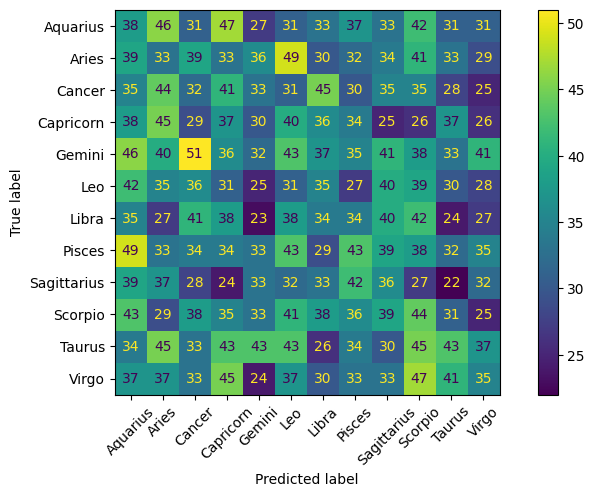

In [51]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

    Aquarius       0.10      0.12      0.11       427
       Aries       0.09      0.08      0.08       428
      Cancer       0.08      0.07      0.08       414
   Capricorn       0.08      0.10      0.09       403
      Gemini       0.09      0.08      0.08       473
         Leo       0.09      0.08      0.08       399
       Libra       0.07      0.08      0.08       403
      Pisces       0.08      0.08      0.08       442
 Sagittarius       0.09      0.08      0.08       385
     Scorpio       0.06      0.05      0.06       432
      Taurus       0.09      0.08      0.08       456
       Virgo       0.10      0.15      0.12       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



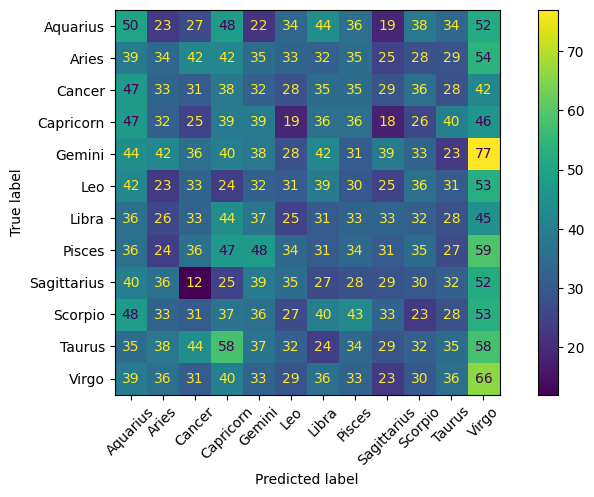

In [52]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

    Aquarius       0.09      0.13      0.11       427
       Aries       0.09      0.12      0.10       428
      Cancer       0.07      0.08      0.08       414
   Capricorn       0.09      0.13      0.10       403
      Gemini       0.08      0.06      0.07       473
         Leo       0.07      0.06      0.07       399
       Libra       0.09      0.10      0.10       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.06      0.04      0.05       385
     Scorpio       0.09      0.08      0.08       432
      Taurus       0.09      0.05      0.07       456
       Virgo       0.08      0.06      0.07       432

    accuracy                           0.09      5094
   macro avg       0.08      0.09      0.08      5094
weighted avg       0.08      0.09      0.08      5094



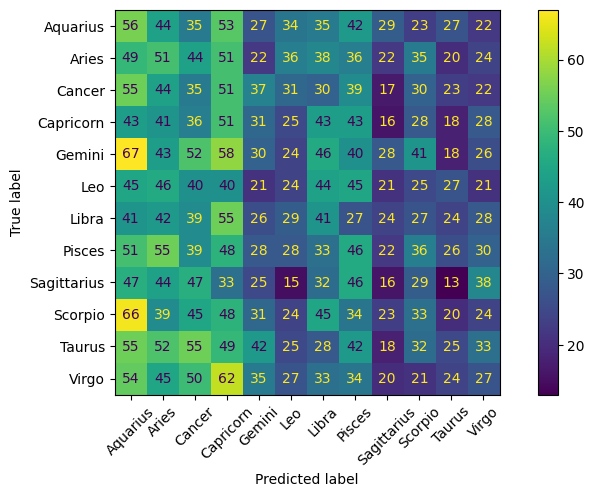

In [53]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

## Page Classification (no lemma, no month)

In [54]:
# Load and clean abstracts
cleaner = clean_tokens(keep_lemma=False)
df['tokens'] = pd.Series([cleaner(doc['abstract']) for doc in docs])
df['tokens'].describe()

count                                                 16978
unique                                                16961
top       [following, list, playboy, playmates, playboy,...
freq                                                     16
Name: tokens, dtype: object

#### Binary Classification

In [55]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, ['Taurus','Sagittarius'])

In [56]:
y_train.value_counts() / len(y_train)

Taurus         0.521119
Sagittarius    0.478881
Name: astral_sign, dtype: float64

In [57]:
y_test.value_counts() / len(y_test)

Taurus         0.542212
Sagittarius    0.457788
Name: astral_sign, dtype: float64

In [58]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1823, 68961), (1823,), (841, 68961), (841,))

##### LogisticRegression

              precision    recall  f1-score   support

 Sagittarius       0.47      0.45      0.46       385
      Taurus       0.55      0.56      0.55       456

    accuracy                           0.51       841
   macro avg       0.51      0.51      0.51       841
weighted avg       0.51      0.51      0.51       841



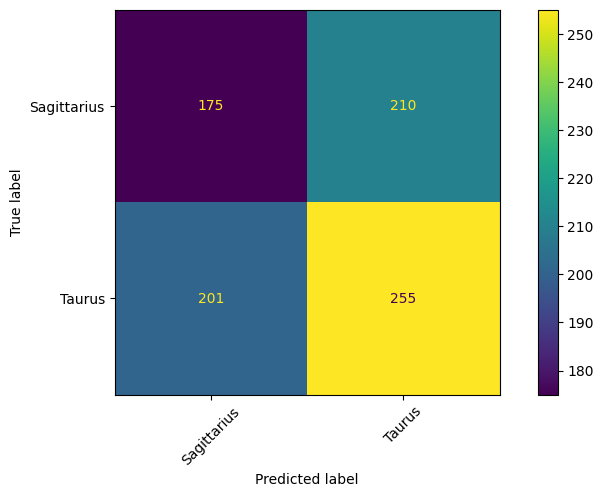

In [59]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

 Sagittarius       0.48      0.47      0.48       385
      Taurus       0.56      0.57      0.56       456

    accuracy                           0.52       841
   macro avg       0.52      0.52      0.52       841
weighted avg       0.52      0.52      0.52       841



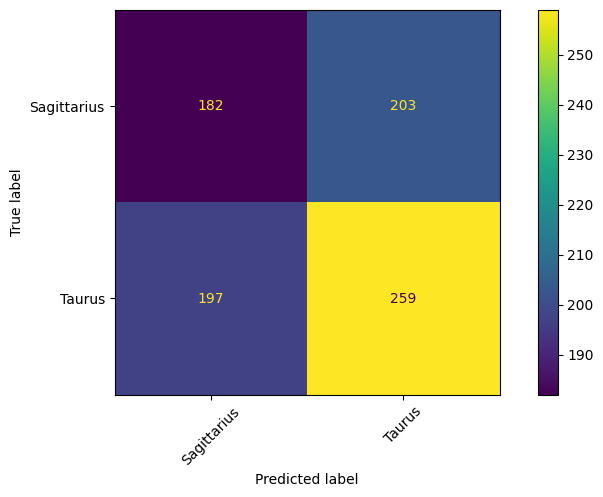

In [60]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

 Sagittarius       0.46      0.45      0.45       385
      Taurus       0.54      0.54      0.54       456

    accuracy                           0.50       841
   macro avg       0.50      0.50      0.50       841
weighted avg       0.50      0.50      0.50       841



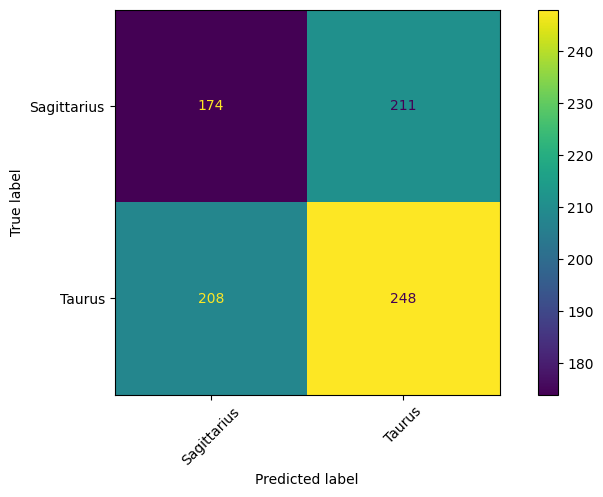

In [61]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

#### Nary Classification

In [62]:
vectorizer =  TfidfVectorizer(token_pattern=r'([^\s]+)')
X_train, y_train, X_test, y_test = vectorize(df, vectorizer, train_indices, test_indices, [])

In [63]:
y_train.value_counts() / len(y_train)

Capricorn      0.088859
Aquarius       0.087176
Aries          0.085577
Libra          0.084652
Cancer         0.084652
Pisces         0.084567
Virgo          0.084399
Scorpio        0.084063
Gemini         0.082716
Taurus         0.079939
Leo            0.079939
Sagittarius    0.073460
Name: astral_sign, dtype: float64

In [64]:
y_test.value_counts() / len(y_test)

Gemini         0.092854
Taurus         0.089517
Pisces         0.086769
Scorpio        0.084806
Virgo          0.084806
Aries          0.084020
Aquarius       0.083824
Cancer         0.081272
Libra          0.079113
Capricorn      0.079113
Leo            0.078327
Sagittarius    0.075579
Name: astral_sign, dtype: float64

In [65]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((11884, 68961), (11884,), (5094, 68961), (5094,))

##### LogisticRegression

              precision    recall  f1-score   support

    Aquarius       0.08      0.09      0.08       427
       Aries       0.07      0.08      0.08       428
      Cancer       0.08      0.08      0.08       414
   Capricorn       0.08      0.09      0.09       403
      Gemini       0.09      0.07      0.08       473
         Leo       0.07      0.08      0.07       399
       Libra       0.08      0.08      0.08       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.08      0.09      0.09       385
     Scorpio       0.09      0.10      0.10       432
      Taurus       0.11      0.09      0.10       456
       Virgo       0.09      0.08      0.09       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



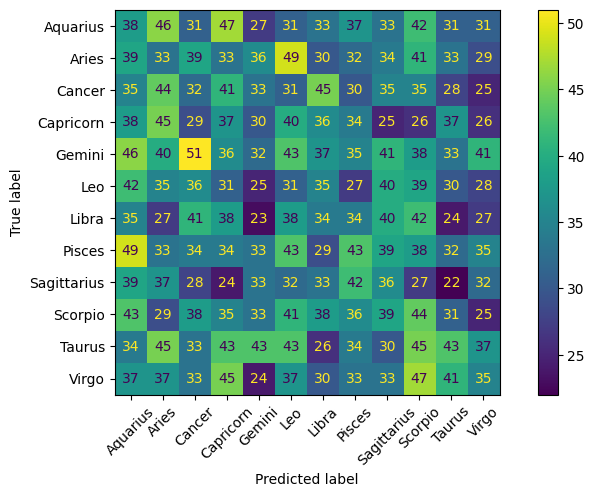

In [66]:
fit_model(
    LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### Perceptron

              precision    recall  f1-score   support

    Aquarius       0.10      0.12      0.11       427
       Aries       0.09      0.08      0.08       428
      Cancer       0.08      0.07      0.08       414
   Capricorn       0.08      0.10      0.09       403
      Gemini       0.09      0.08      0.08       473
         Leo       0.09      0.08      0.08       399
       Libra       0.07      0.08      0.08       403
      Pisces       0.08      0.08      0.08       442
 Sagittarius       0.09      0.08      0.08       385
     Scorpio       0.06      0.05      0.06       432
      Taurus       0.09      0.08      0.08       456
       Virgo       0.10      0.15      0.12       432

    accuracy                           0.09      5094
   macro avg       0.09      0.09      0.09      5094
weighted avg       0.09      0.09      0.09      5094



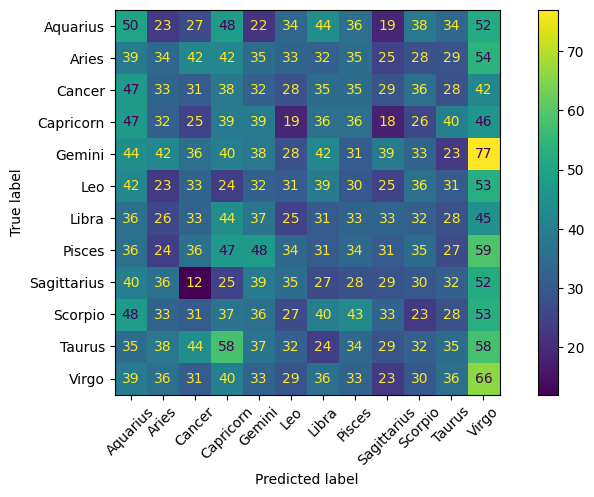

In [67]:
fit_model(
    Perceptron(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)

##### RandomForest

              precision    recall  f1-score   support

    Aquarius       0.09      0.13      0.11       427
       Aries       0.09      0.12      0.10       428
      Cancer       0.07      0.08      0.08       414
   Capricorn       0.09      0.13      0.10       403
      Gemini       0.08      0.06      0.07       473
         Leo       0.07      0.06      0.07       399
       Libra       0.09      0.10      0.10       403
      Pisces       0.10      0.10      0.10       442
 Sagittarius       0.06      0.04      0.05       385
     Scorpio       0.09      0.08      0.08       432
      Taurus       0.09      0.05      0.07       456
       Virgo       0.08      0.06      0.07       432

    accuracy                           0.09      5094
   macro avg       0.08      0.09      0.08      5094
weighted avg       0.08      0.09      0.08      5094



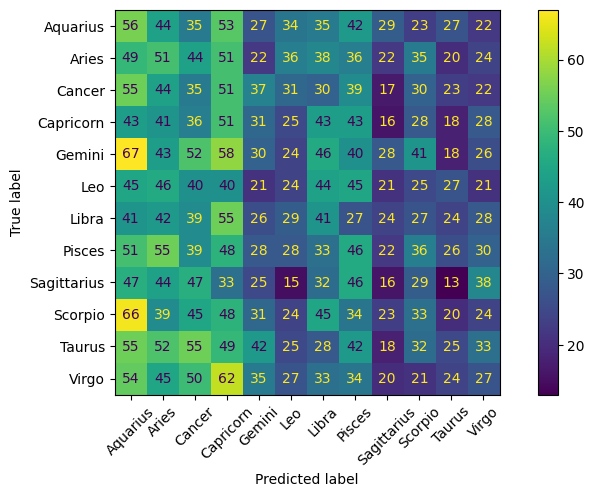

In [68]:
fit_model(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1), 
    X_train, y_train,
    X_test, y_test
)